# Iskanje besed, specifičnih za dokumente z uporabo metode RAKE

Tokrat bomo poskusili specifične besede v dokumentu določiti z uporabo metode na grafih. Uporabili bomo metodo [RAKE - Rapid Automatic Keyword Extraction](https://www.researchgate.net/publication/227988510_Automatic_Keyword_Extraction_from_Individual_Documents). Metoda zgradi graf sopojavitev besed ter na podlagi grafa točkuje besede in fraze.

In [1]:
import string

import pandas as pd
from textsemantics.server_api import ServerAPI
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE

from utils.specific_words import rake_words, rake_phrases, prepare_data

Iz seznama predlogov vladi izberemo zadnjih 100 dokumentov.

In [2]:
api = ServerAPI()
metadata = api.get_metadata('predlogi-vladi', sample_size=100, sampling_strategy='latest')

texts = api.get_texts(urls=metadata['text'])
texts = [text for text in texts if len(text) > 50]

Izberemo, koliko najvišje rangiranih besed nas zanima.

In [3]:
num_of_words = 10

Pripravimo funkcijo za prikaz besedil in specifičnih besed

In [4]:
from IPython.display import display, Markdown

def display_document_and_specific_words(doc_ind): 
    title = f"### {metadata.loc[doc_ind, 'title']}"
    display(Markdown('\n'.join((title, texts[doc_ind]))))
    
    top_words = rake_words([texts[doc_ind]])[0]
    display(pd.DataFrame(top_words[:num_of_words], columns=["Word", "Score"]))

Poglejmo dva dokumenta in 5 najbolj specifičnih besed, ki jih najde metoda RAKE.

In [5]:
display_document_and_specific_words(4)

### Sprememba stopnje DDV za stanovanjske nepremičnine
Trenutna obdavčitev je 9,5% za stanovanja do 120m2 in hiše do 250m2. Če površina presega cenzus, se na celotno ceno obračuna DDV po stopnji 22%. Posledično je stanovanje površine 121m2 več kot dvakrat bolj obdavčeno, kot stanovanje površine 119m2, kar je absurdno.
Predlagam, da se obdavčitev spremeni tako, da je površina do 120m2 stanovanja oz. 250m2 hiše vedno obdavčena po 9,5%. Površina, ki presega cenzus, pa naj bo višje obdavčena.

,Word,Score
0,121m2,4.0
1,več,4.0
2,vedno,4.0
3,celotno,4.0
4,ceno,4.0
5,obračuna,4.0
6,ddv,4.0
7,stanovanje,3.5
8,površine,3.5
9,oz,3.0


In [6]:
display_document_and_specific_words(13)

### Videvanja z partnerjem z tujine med epidemijo.
Predlagam, da se kot izjema za prehajanje regije, občine ali državne meje, uvede tudi vzdrževanje stikov z partnerji iz tujine. Sam, kot tudi drugi smo namreč zaradi tega prizadeti, saj nas veliko živi ob meji s Hrvaško na primer, 15 min vožnje stran eden od drugega, a zaradi restriktivnih srečanje ni možno, čez Kolpo si pa lahko mahamo. Je bil 1. Val dovolj, da se nisem mogel videti s punco, katere tudi skoraj nisem prepoznal, po 2 mesecih razdvojenosti. Lp

,Word,Score
0,15,4.0
1,min,4.0
2,vožnje,4.0
3,stran,4.0
4,2,3.0
5,mesecih,3.0
6,razdvojenosti,3.0
7,veliko,2.0
8,živi,2.0
9,državne,2.0


## Dendrogram z specifičnimi besedami

Sedaj, ko imamo postopek za računanje specifičnih besed, lahko te prikažemo v dendrogramu, ki prikazuje podobnosti med dokumenti. Ker bi bil dendrogram z vsemi dokumenti preobsežen, se odločimo za dokuemnte, ki smo jih že obravnavali v zvezku `03_02_distances_and_similarities`.

Preprocesirajmo dokumente za namen računanja razdalj

In [7]:
def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = RegexpTokenizer("\w+")
    lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        preprocessed.append(tokens)
        
    return preprocessed

tokens_list = preprocess(texts)

V dendrogramu prikažimo podobnost in specifične besede.

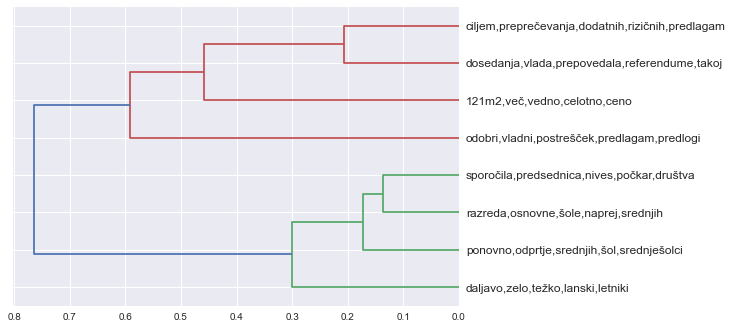

In [8]:
idx = [7, 18, 20, 30, 1, 2, 3, 4]

# dendrogram
plt.style.use('seaborn')
emb, _, _, _, _ = prepare_data([tokens_list[i] for i in idx])
dist_mat = 1 - cosine_similarity(emb)
linkage = ward(dist_mat)

# specific words
spec_words = [rake_words([texts[i]])[0] for i in idx]
spec_words = [",".join(w for w, _ in ws[:5]) for ws in spec_words]
dendrogram(
    linkage, color_threshold=0.6, 
    labels=spec_words,
    orientation="left"
);

## Specifične fraze

Metoda RAKE je bolj kot za specifične besede primerna za iskanje specifičnih fraz, zato v tem primeru pokažimo še najbolj pomembene fraze za izbrana dva dokumenta.

In [9]:
from IPython.display import display, Markdown

def display_document_and_specific_phrases(doc_ind): 
    title = f"### {metadata.loc[doc_ind, 'title']}"
    display(Markdown('\n'.join((title, texts[doc_ind]))))
    
    top_words = rake_phrases([texts[doc_ind]])[0]
    display(pd.DataFrame(top_words[:num_of_words], columns=["Word", "Score"]))

In [10]:
display_document_and_specific_phrases(4)

### Sprememba stopnje DDV za stanovanjske nepremičnine
Trenutna obdavčitev je 9,5% za stanovanja do 120m2 in hiše do 250m2. Če površina presega cenzus, se na celotno ceno obračuna DDV po stopnji 22%. Posledično je stanovanje površine 121m2 več kot dvakrat bolj obdavčeno, kot stanovanje površine 119m2, kar je absurdno.
Predlagam, da se obdavčitev spremeni tako, da je površina do 120m2 stanovanja oz. 250m2 hiše vedno obdavčena po 9,5%. Površina, ki presega cenzus, pa naj bo višje obdavčena.

,Word,Score
0,celotno ceno obračuna ddv,16.0
1,stanovanje površine 121m2 več,15.0
2,250m2 hiše vedno obdavčena,12.0
3,stanovanje površine 119m2,10.0
4,dvakrat bolj obdavčeno,9.0
5,stopnji 22 %.,8.5
6,površina presega cenzus,7.0
7,120m2 stanovanja oz,7.0
8,višje obdavčena,5.0
9,presega cenzus,5.0


In [11]:
display_document_and_specific_phrases(13)

### Videvanja z partnerjem z tujine med epidemijo.
Predlagam, da se kot izjema za prehajanje regije, občine ali državne meje, uvede tudi vzdrževanje stikov z partnerji iz tujine. Sam, kot tudi drugi smo namreč zaradi tega prizadeti, saj nas veliko živi ob meji s Hrvaško na primer, 15 min vožnje stran eden od drugega, a zaradi restriktivnih srečanje ni možno, čez Kolpo si pa lahko mahamo. Je bil 1. Val dovolj, da se nisem mogel videti s punco, katere tudi skoraj nisem prepoznal, po 2 mesecih razdvojenosti. Lp

,Word,Score
0,15 min vožnje stran,16.0
1,2 mesecih razdvojenosti,9.0
2,vzdrževanje stikov,4.0
3,veliko živi,4.0
4,val dovolj,4.0
5,restriktivnih srečanje,4.0
6,prehajanje regije,4.0
7,lahko mahamo,4.0
8,državne meje,4.0
9,videti,1.0
